In [1]:
import math
import numpy as np

from bloqade import rydberg_h, piecewise_linear, piecewise_constant, waveform, cast
from bloqade.atom_arrangement import ListOfLocations, Lieb, Square, Chain, Honeycomb, Kagome, Triangular, Rectangular
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
import os
import matplotlib.pyplot as plt

import pickle
import time

from scipy.signal import convolve2d
from pathlib import Path
import os
import re

output_notebook()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading BokehJS ...

In [2]:
def circle_kernel(radius):
    kernel_size = int(np.floor(radius))*2+1
    kernel = np.zeros((kernel_size, kernel_size))
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (radius)**2 >= (i-int(radius))**2+(j-int(radius))**2:
                kernel[i][j] = 1
    kernel[int(radius)][int(radius)] = 0
    return kernel


def is_independent(arr, kernel, radius, return_missed=True):
    kernel_sum = np.sum(kernel)
    padded = np.pad(arr, int(radius), constant_values=1)
    convolved = convolve2d(padded, kernel, mode="valid")

    # print(arr)
    # print(convolved)
    # print((convolved[np.bitwise_not(arr.astype(bool))] == kernel_sum).astype(int))
    # print()
    is_independent = np.all(convolved[np.bitwise_not(arr.astype(bool))] == kernel_sum)

    if return_missed:
        return is_independent, ((convolved == kernel_sum) ^ arr).astype(bool)
    else: 
        return is_independent

In [7]:
r_array = np.array([2, np.sqrt(5), np.sqrt(2*np.sqrt(2)*np.sqrt(5)), 2*np.sqrt(2), np.sqrt(2*np.sqrt(2)*3)])
d_maxs = np.array([(862690/((4*r)**6)) for r in r_array])

In [8]:
def independent_set_probabilities(save_path):
    data = {}
    ind = 0
    for pickle_file in list(Path(f"{save_path}/").glob('*.pickle')):
            with pickle_file.open('rb') as file: 
                if not pickle_file.name.endswith("indep_set_probabilities.pickle"):
                    sweep_data = pickle.load(file)
                    # step = int(''.join(re.findall(r'\d', pickle_file.stem)))
                    data[ind]= {}

                    d_max = sweep_data["d_max"]
                    Om_max = sweep_data["Om_max"]
                    radius = r_array[np.absolute(d_maxs-d_max).argmin()]
                    kernel = circle_kernel(radius)
                    x_size, y_size = 5, 5
                    arrays = sweep_data["bitstrings"][0]

                    unique, counts = np.unique(arrays, axis=0, return_counts=True)

                    indep_sets_idx = []
                    cardininalities = []
                    for i, array in list(enumerate(unique)):
                        if is_independent(array.reshape(x_size, y_size), kernel, radius, return_missed=False):
                            indep_sets_idx.append(i)
                            cardininalities.append(array.size - np.sum(array))

                    indep_sets_idx = np.array(indep_sets_idx)[np.argsort(cardininalities)]
                    cardininalities = np.array(np.sort(cardininalities))

                    prob = []
                    for c in np.unique(cardininalities):
                        fixed_card = indep_sets_idx[np.where(cardininalities==c)]
                        prob.append(np.sum(counts[fixed_card])/np.sum(counts))

                    data[ind]["prob"] = prob[::-1]
                    data[ind]["cardinality"] = np.unique(cardininalities)[::-1]
                    data[ind]["radius"] = radius
                    data[ind]["d_to_Om"] = d_max/Om_max
                    data[ind]["d_max"] = d_max
                    data[ind]["Om_max"] = Om_max
            ind = ind + 1

    with open(f'{save_path}/indep_set_probabilities.data', 'wb') as file:
        pickle.dump(data, file)

In [9]:
def plot_set_probabilites(save_path, title):
    with Path(f"{save_path}/indep_set_probabilities.data").open('rb') as file: 
        data = pickle.load(file)

        
    for r in r_array:
        print(r)
        for i, (y, details) in enumerate(sorted(data.items(), key = lambda x: x[0])):
            if details['radius'] == r:
                fig = plt.figure(figsize=(10,7), dpi=150)
                print(details['d_to_Om'])
                plt.bar(details['cardinality'], details['prob'])
                plt.show()

2.0
1.5


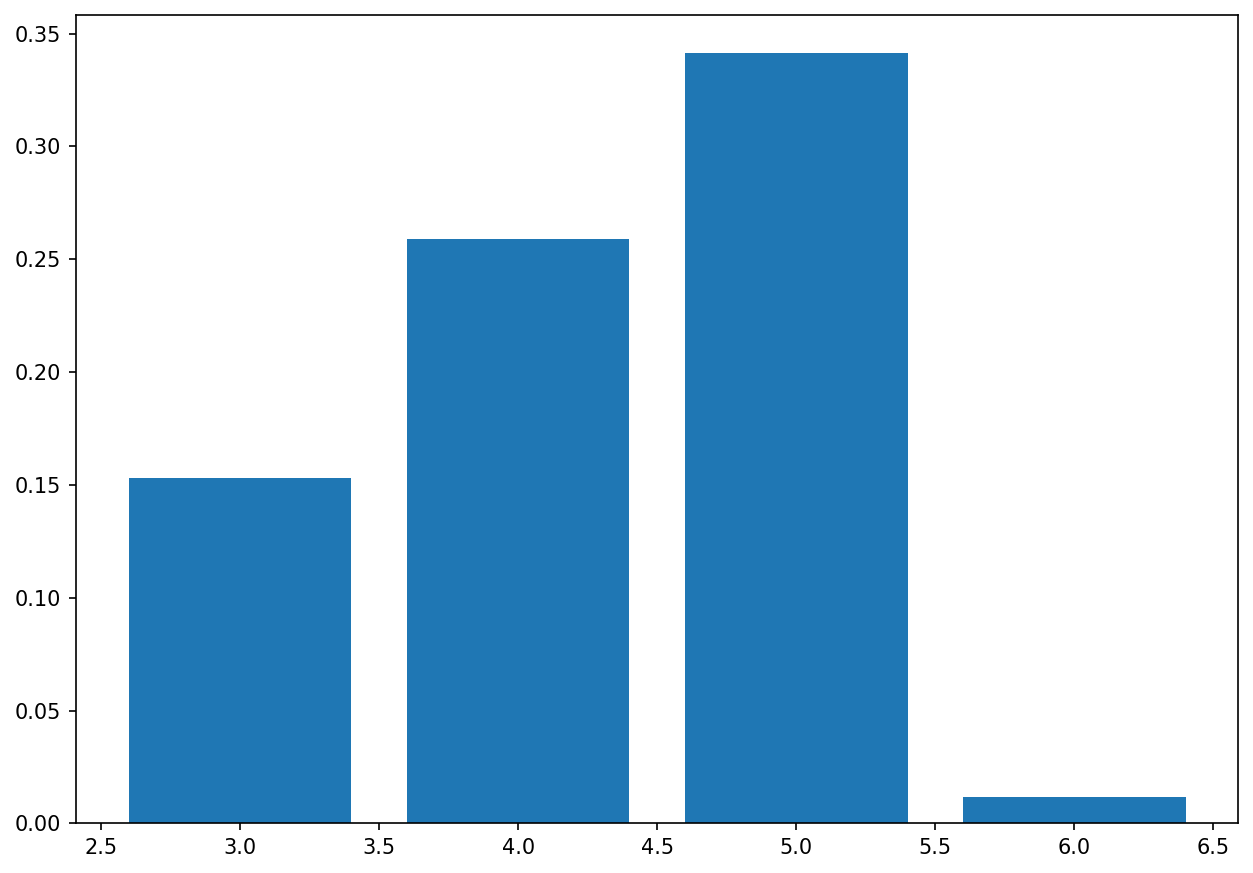

1.5


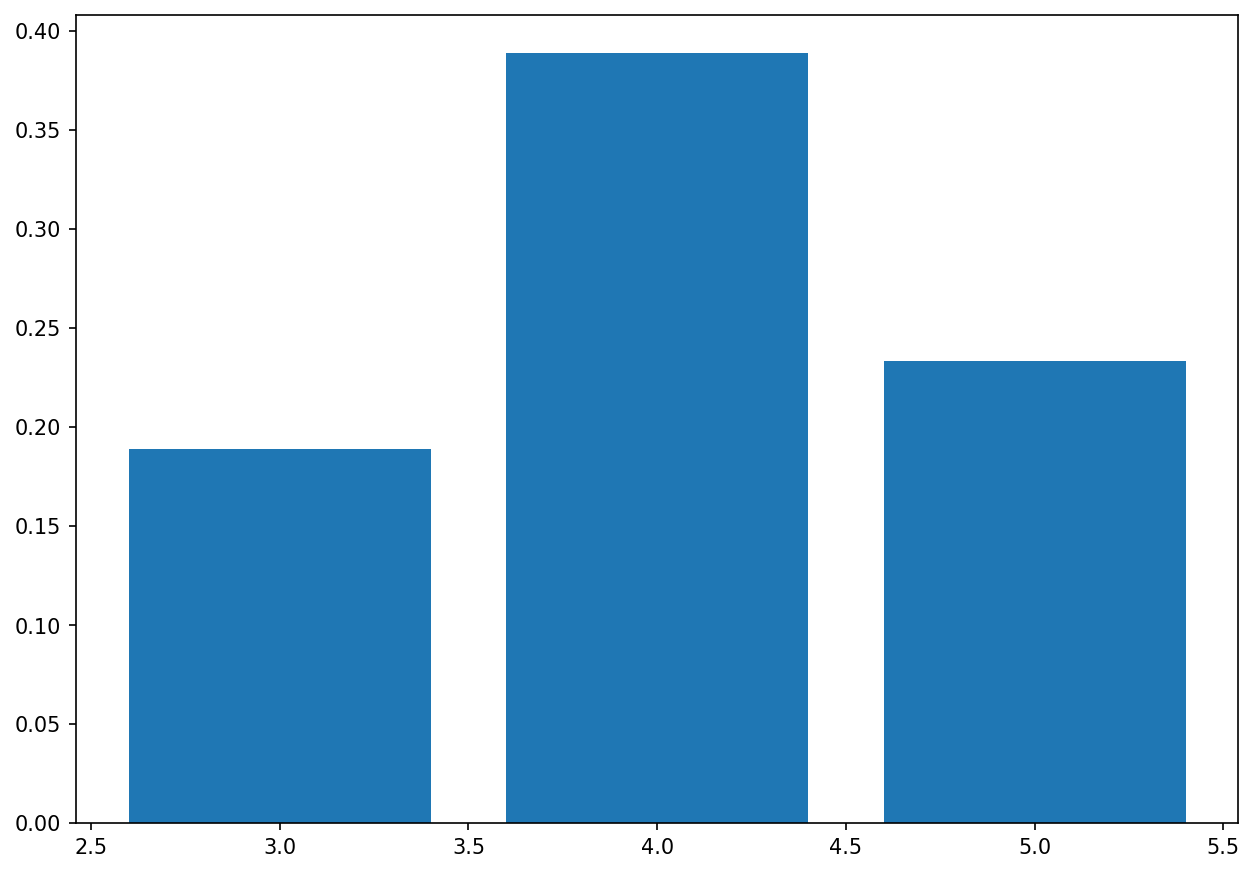

1.5


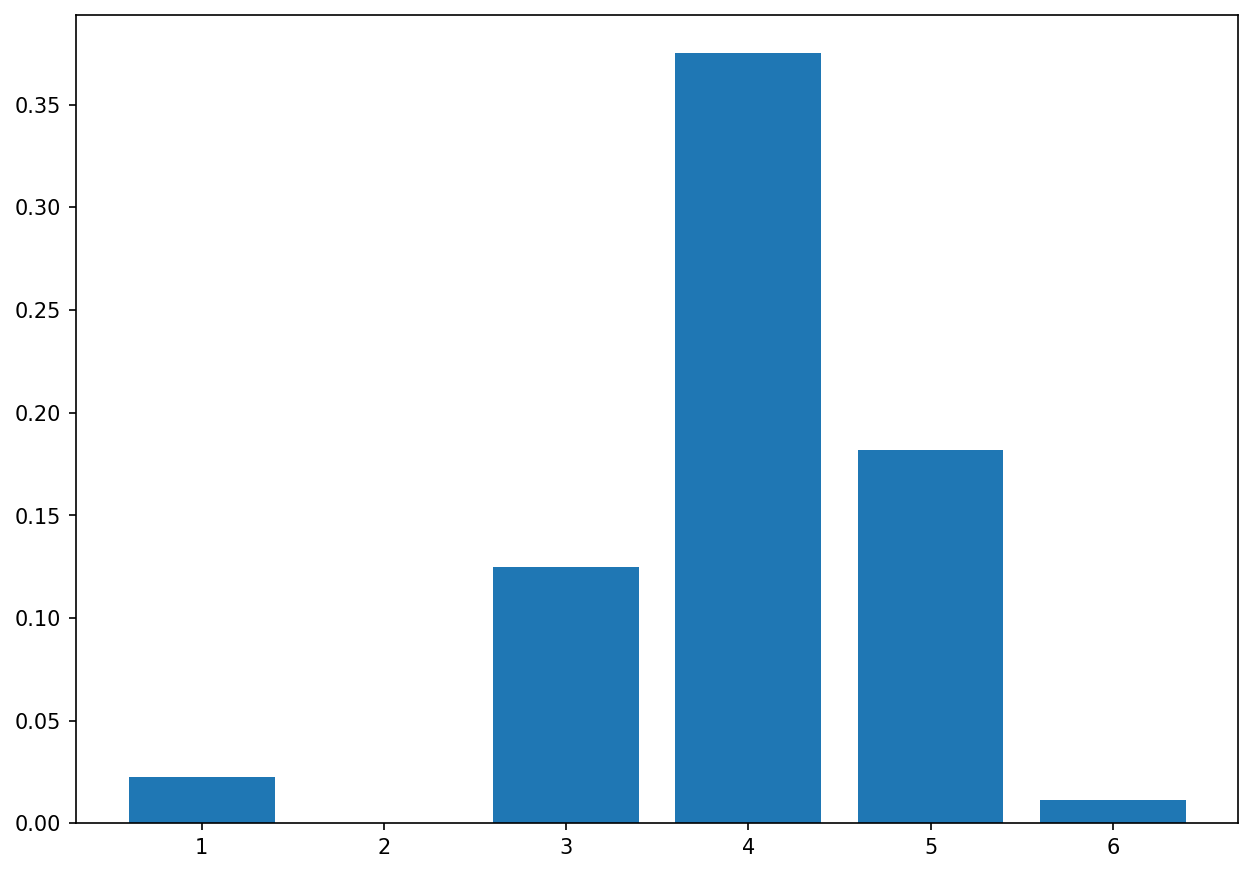

1.5


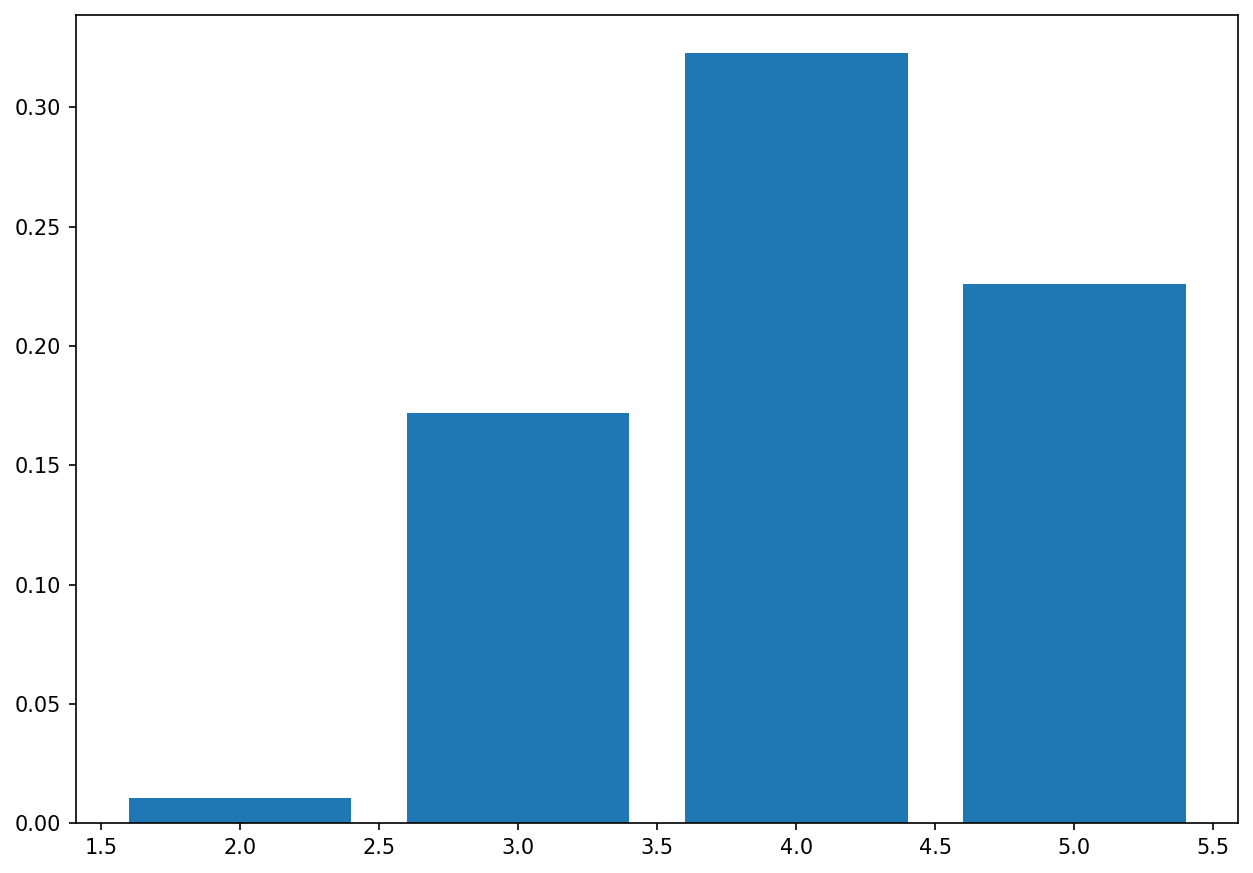

2.23606797749979
1.5


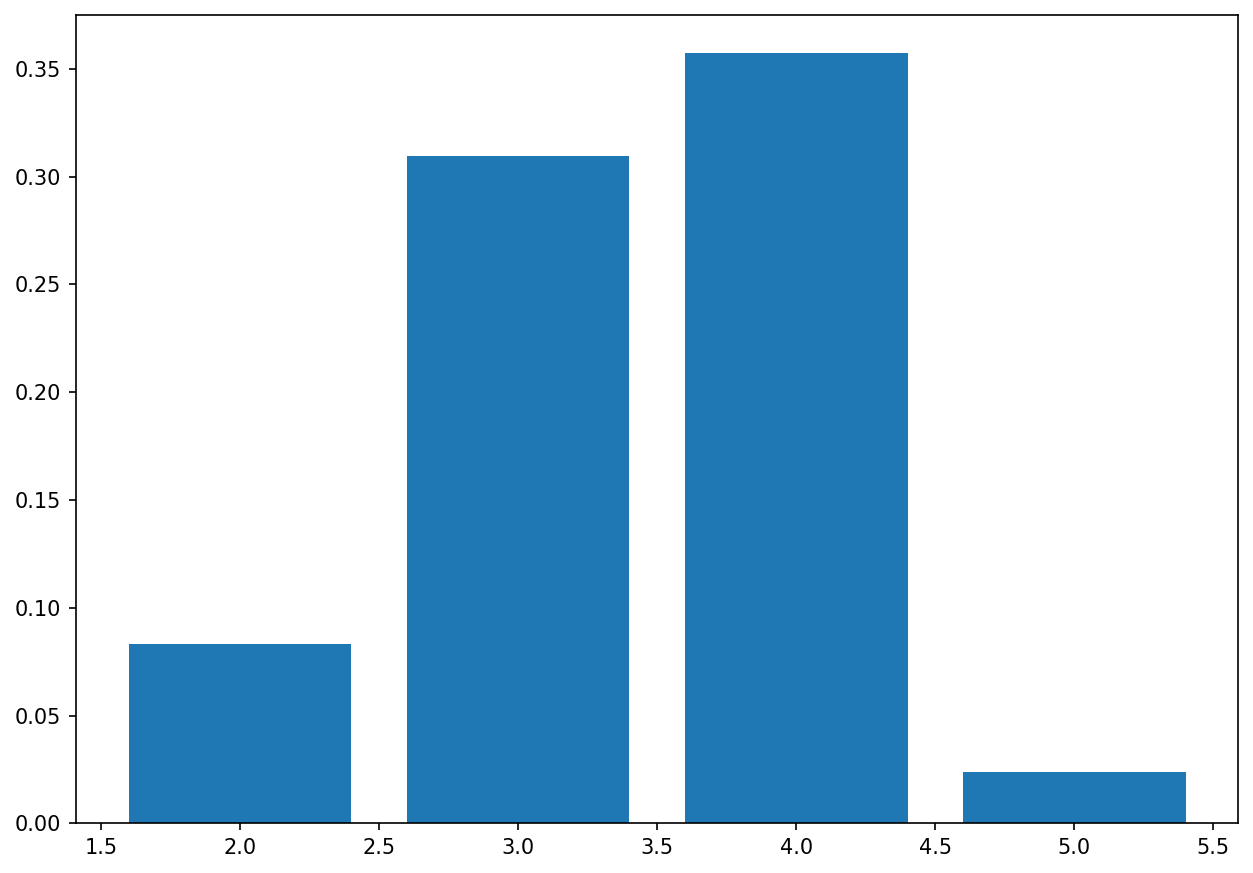

1.5


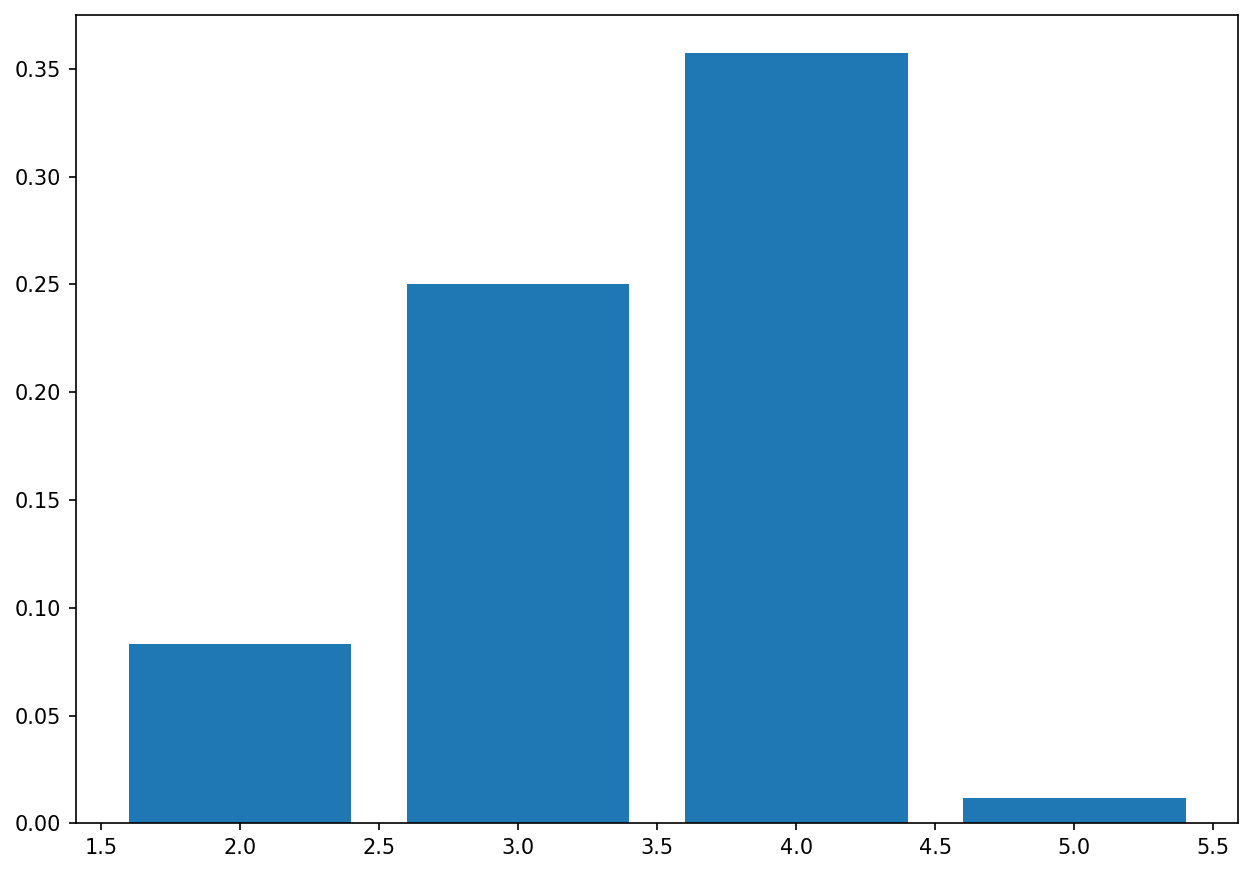

1.5


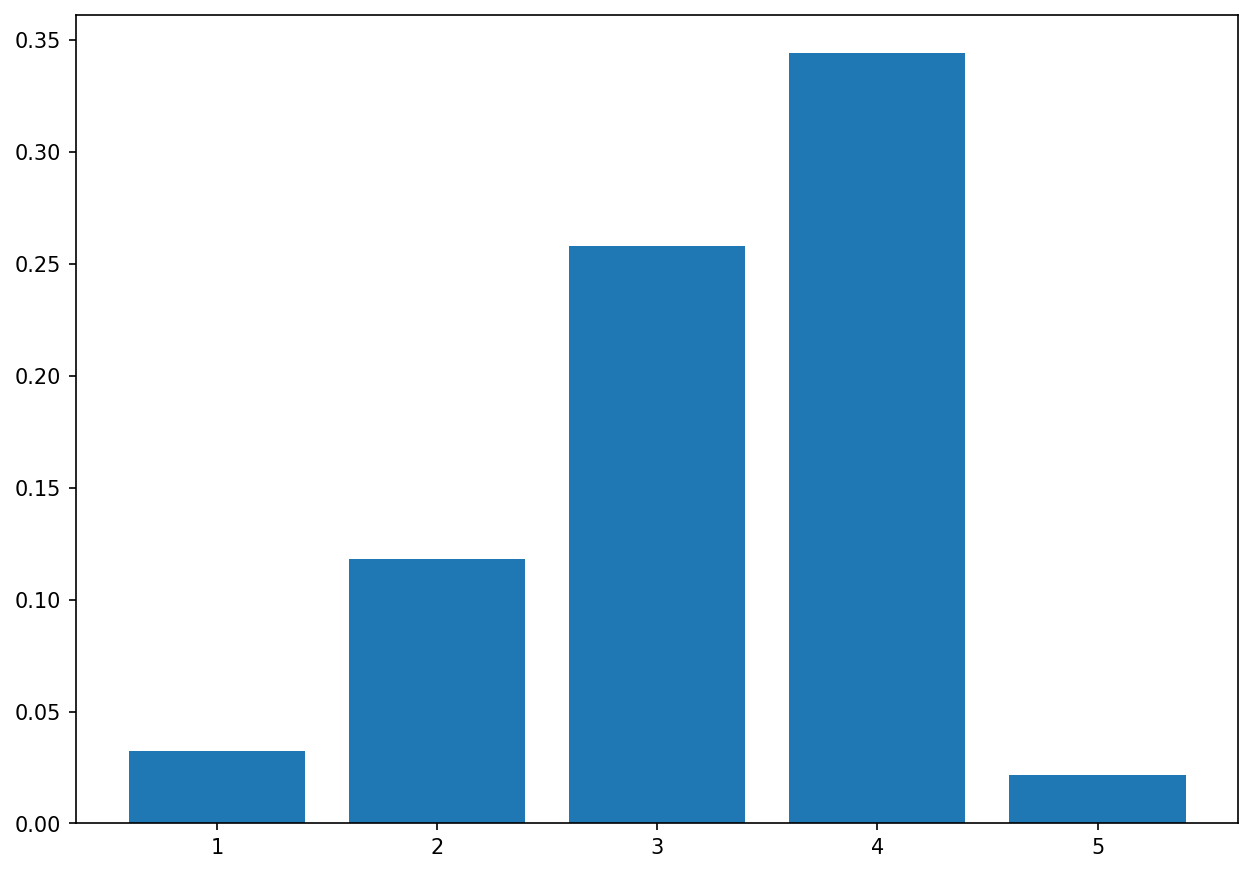

1.5


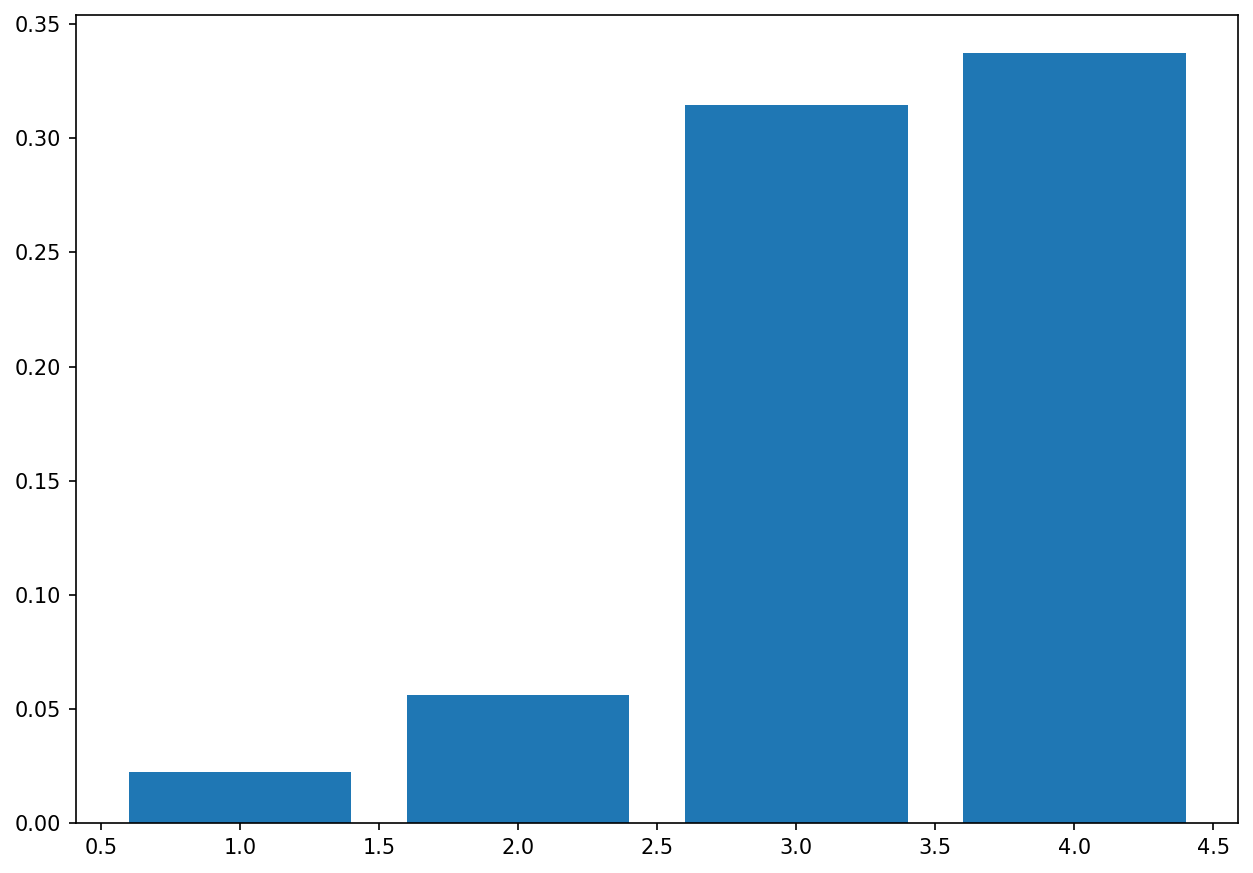

2.514866859365871
1.5


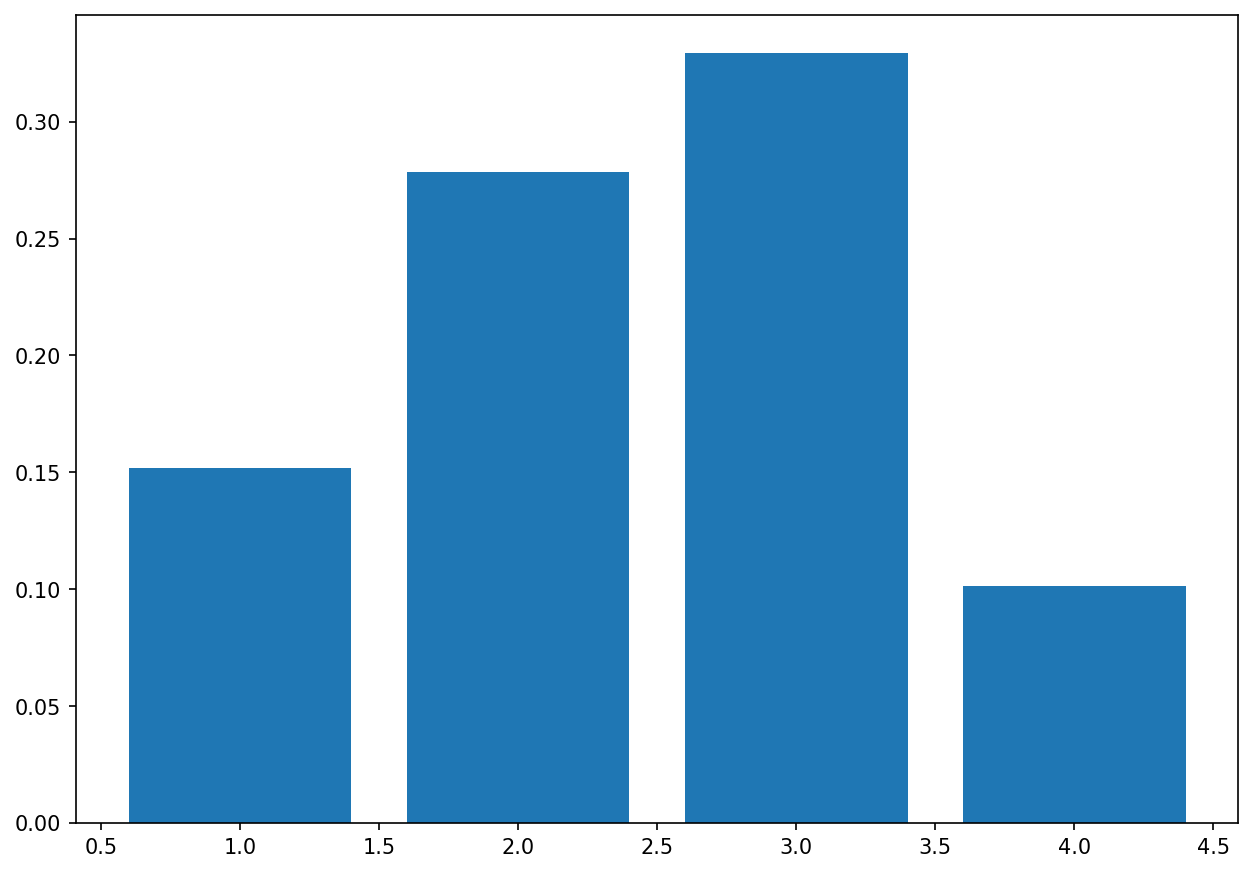

1.5


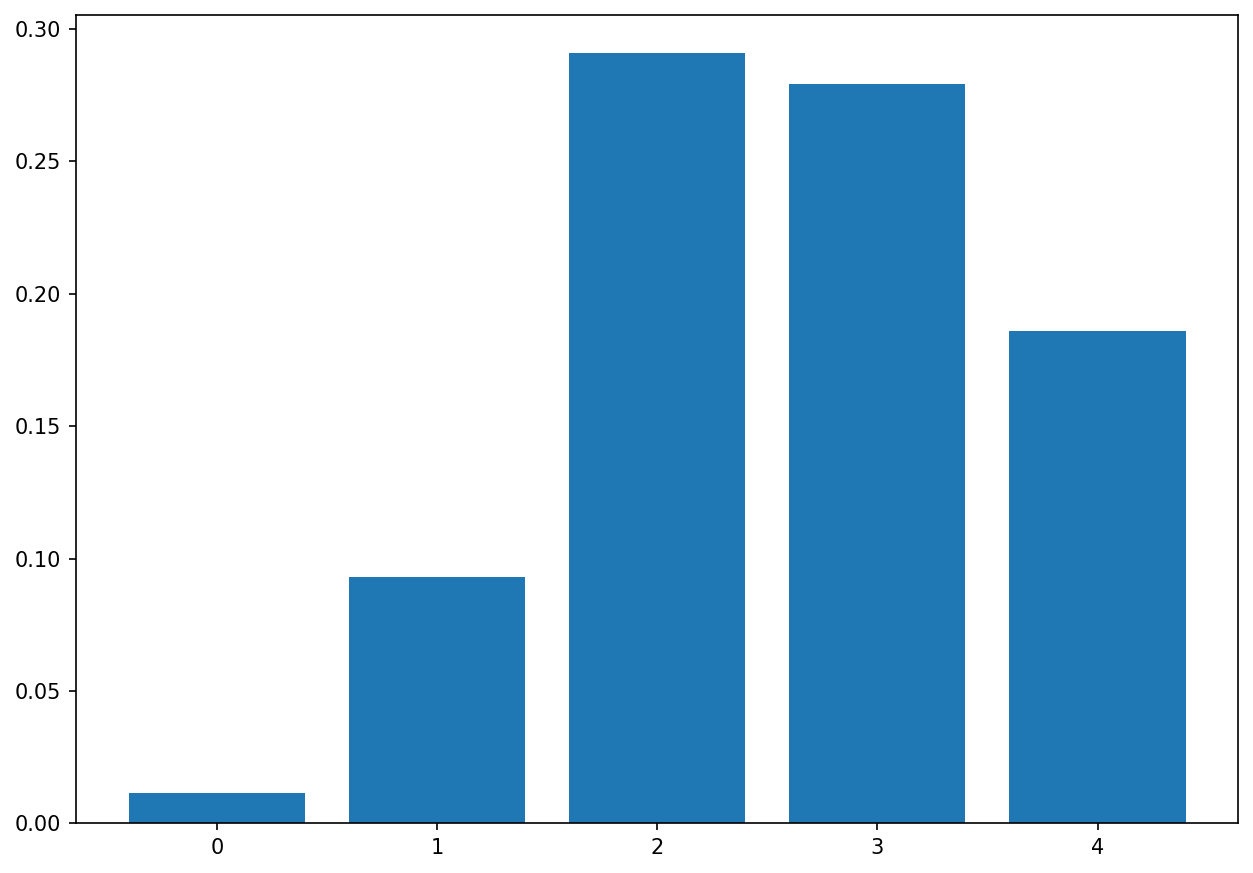

1.5


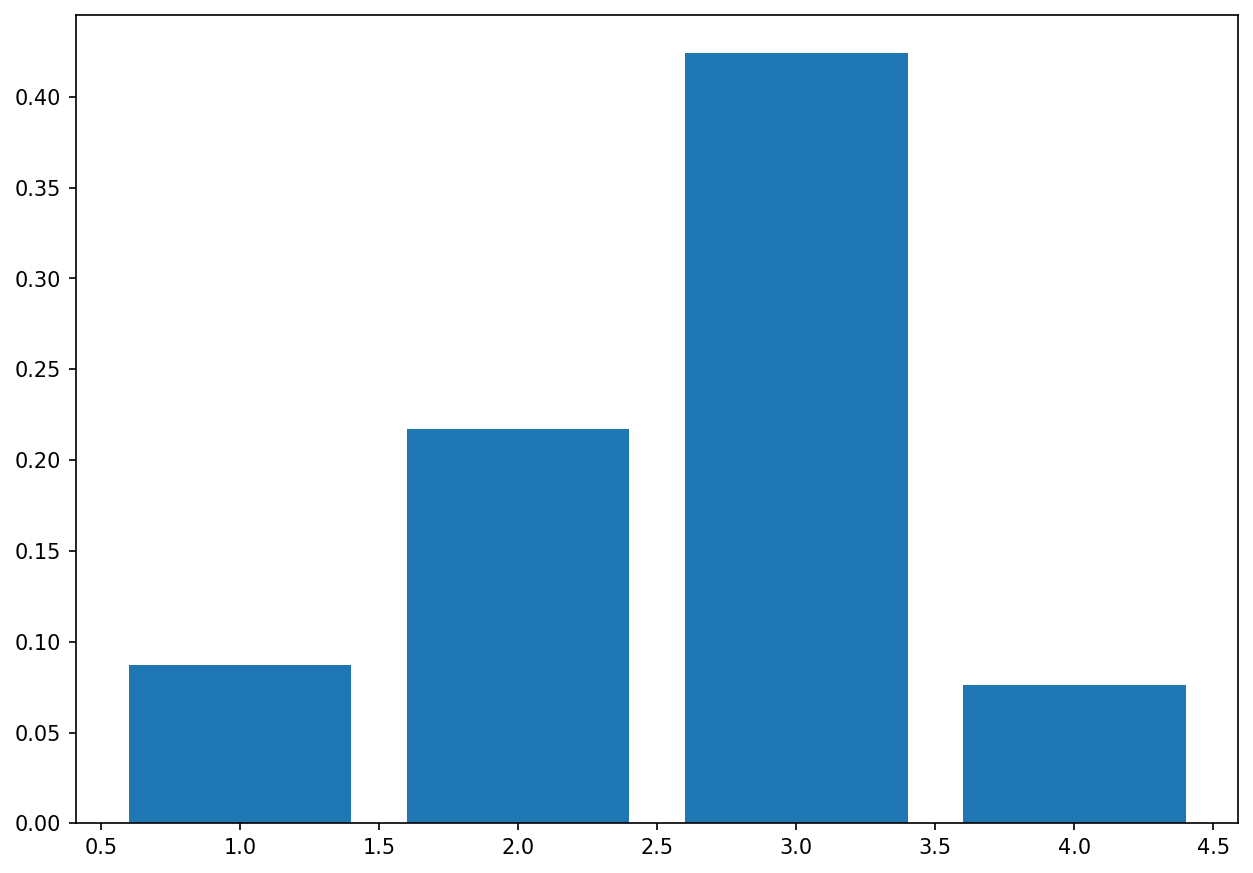

1.5


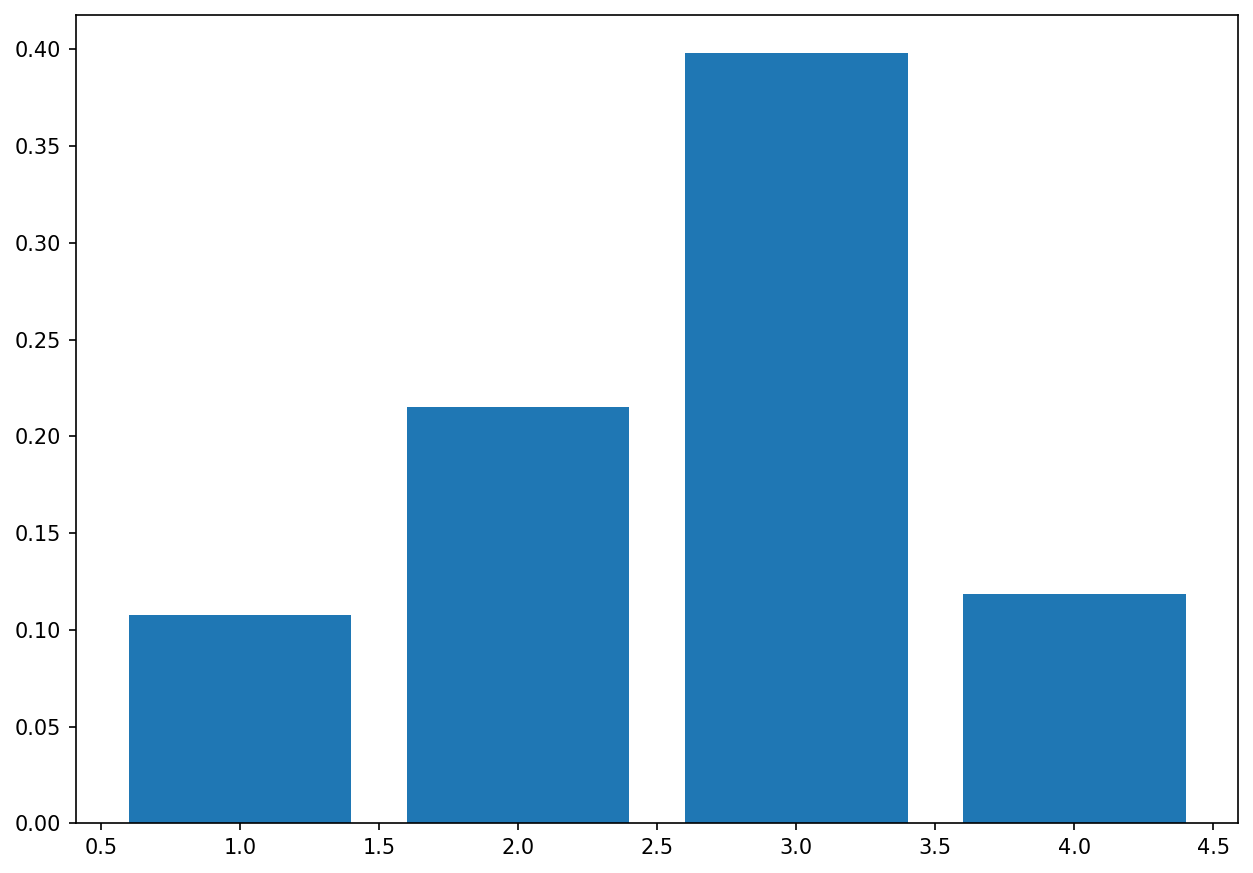

2.8284271247461903
1.5


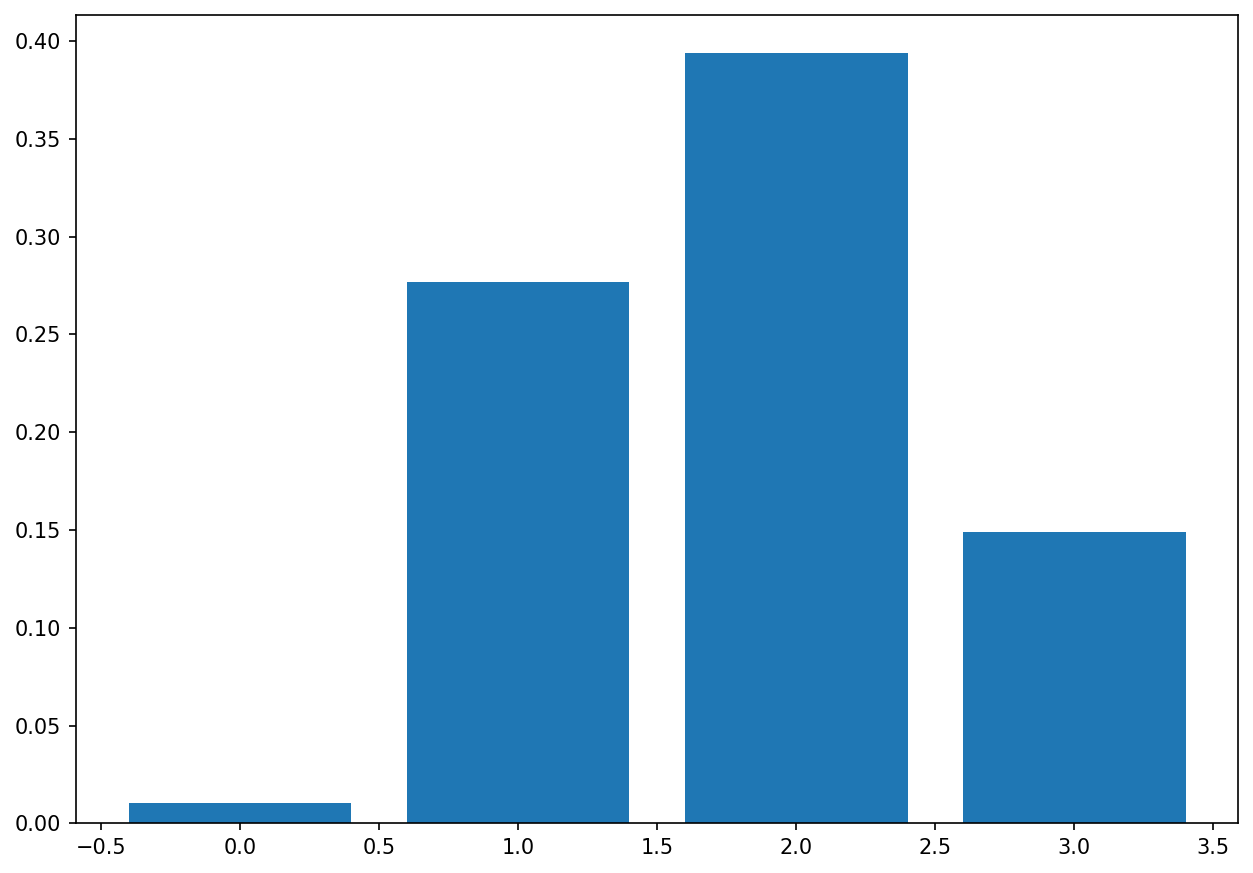

1.5


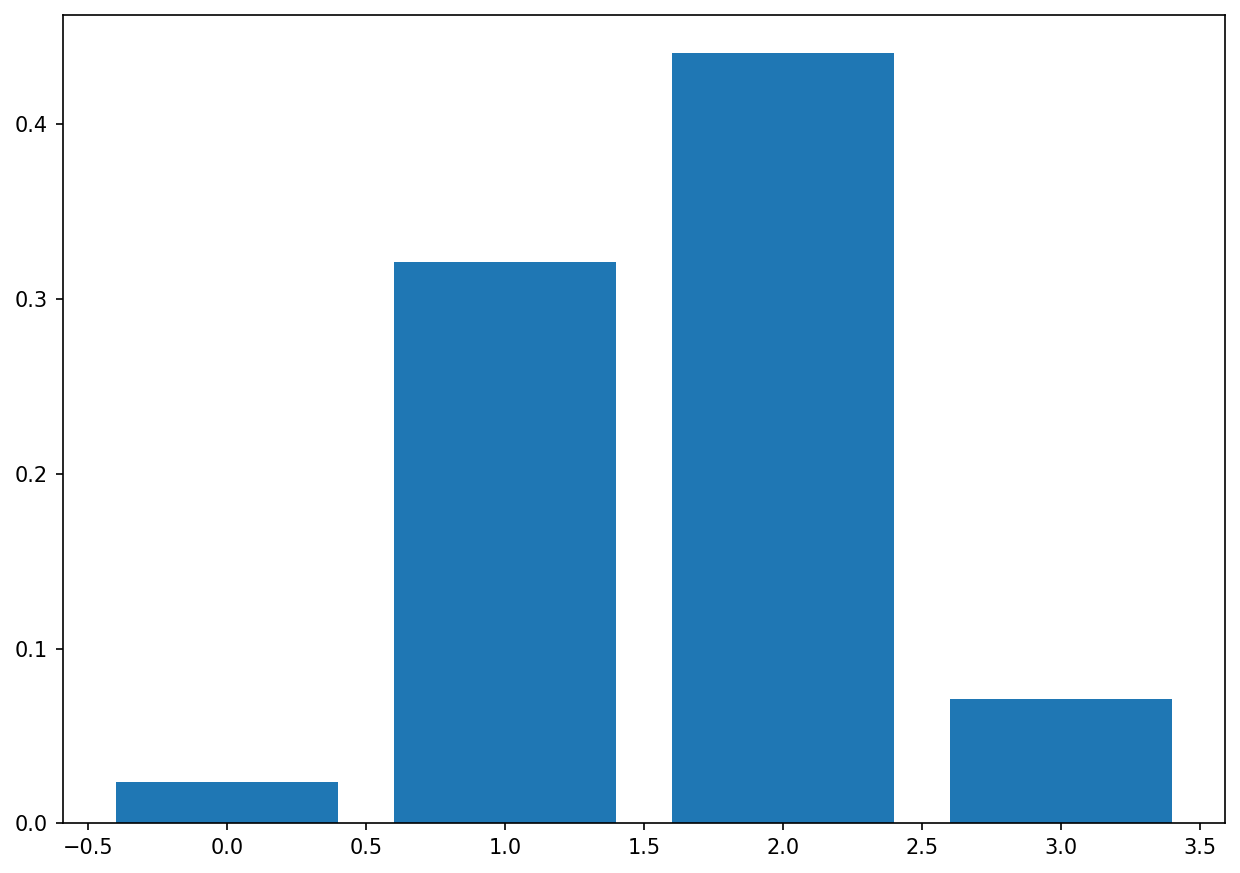

1.5


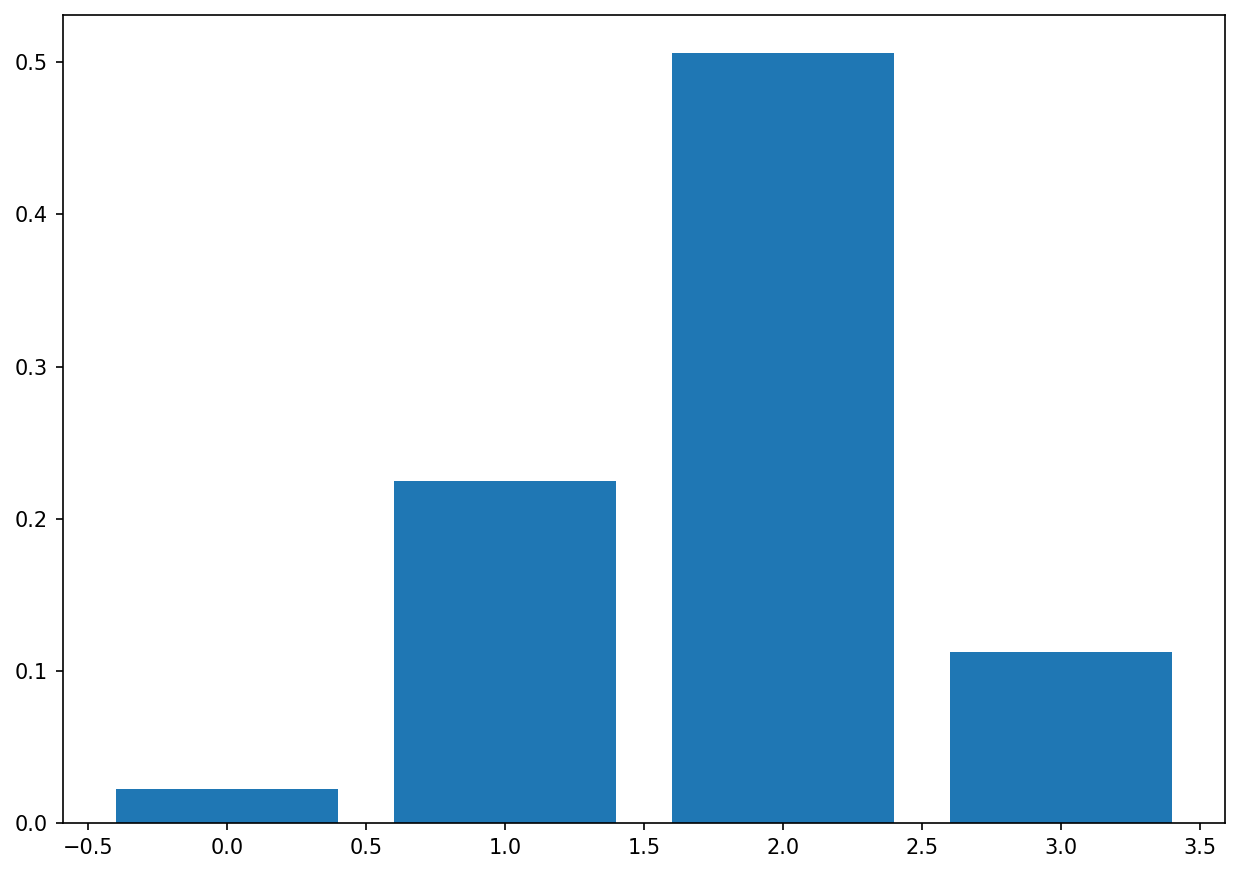

1.5


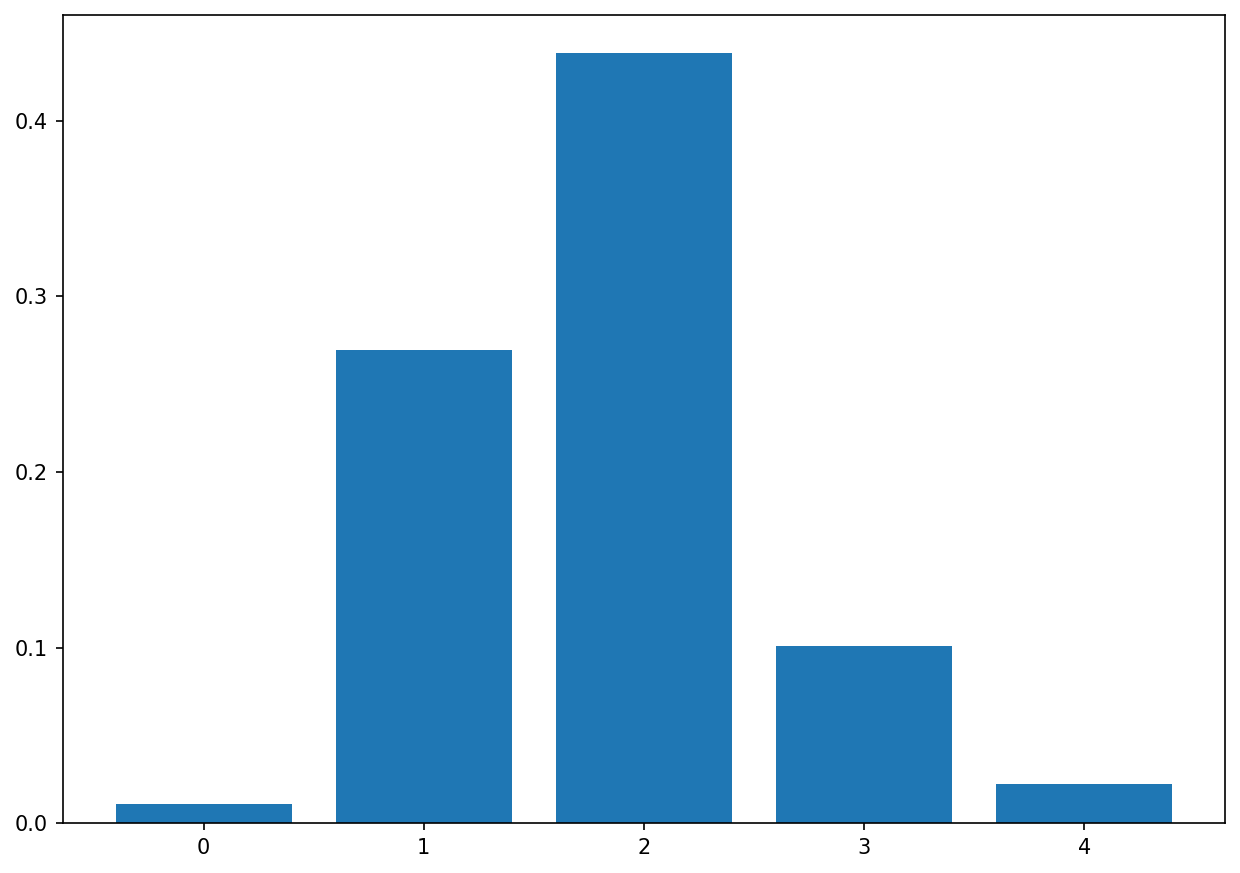

2.9129506302439405
1.5


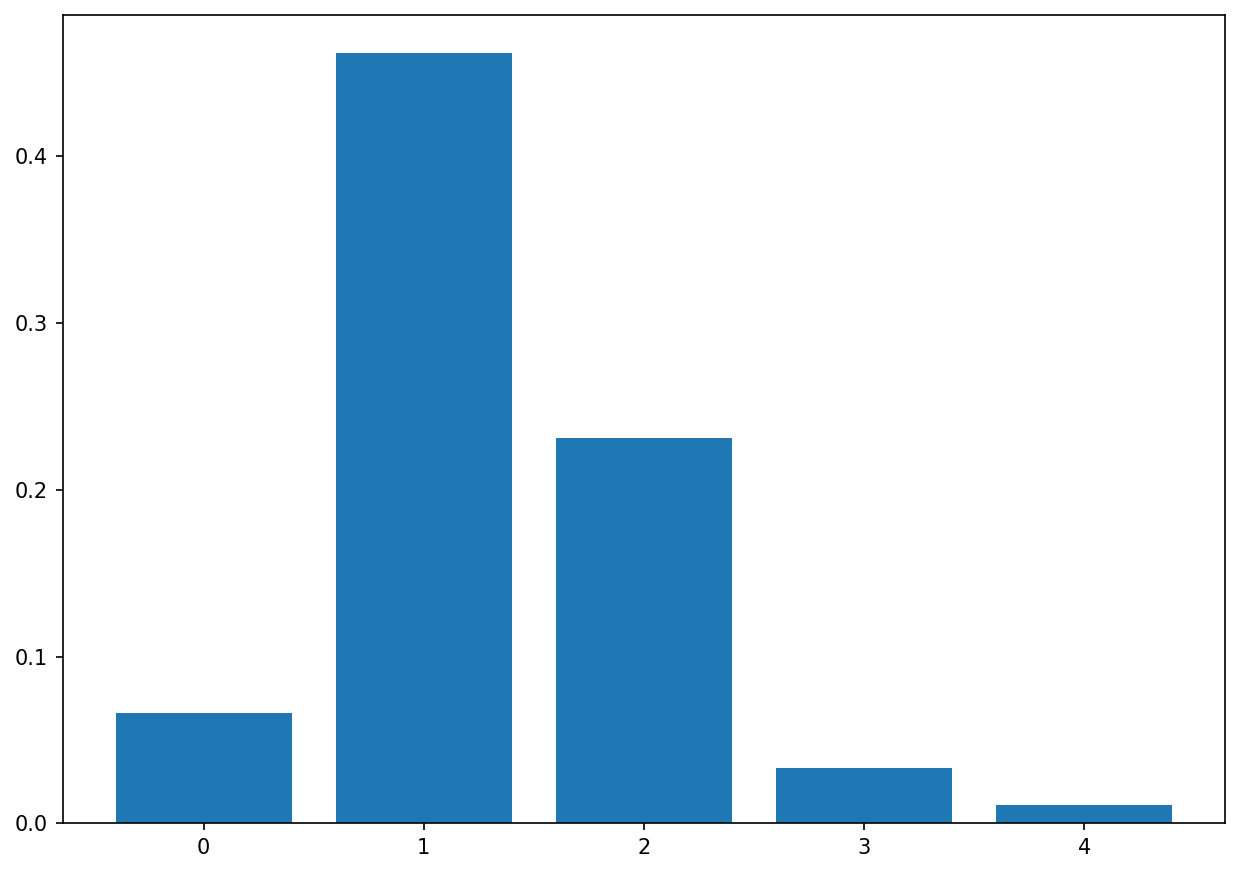

1.5


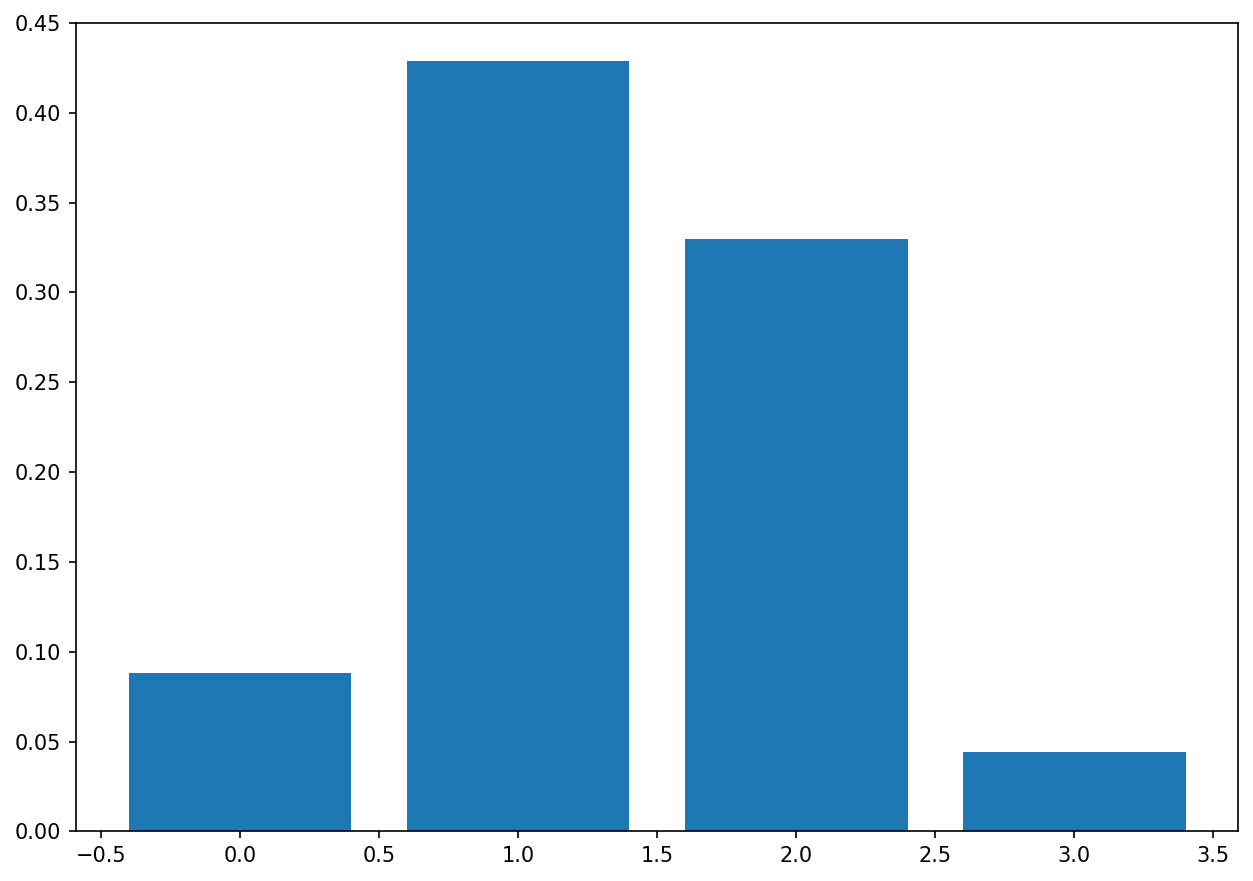

1.5


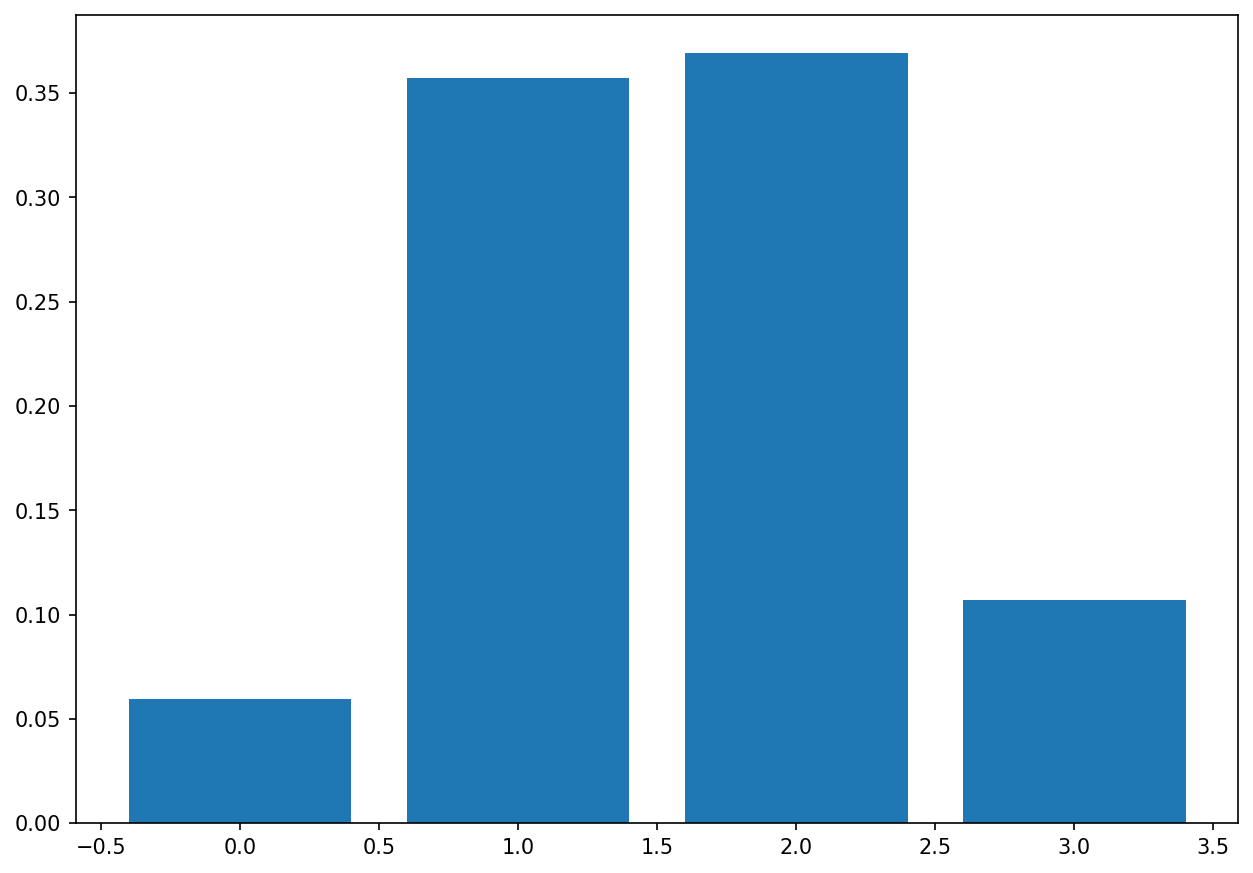

1.5


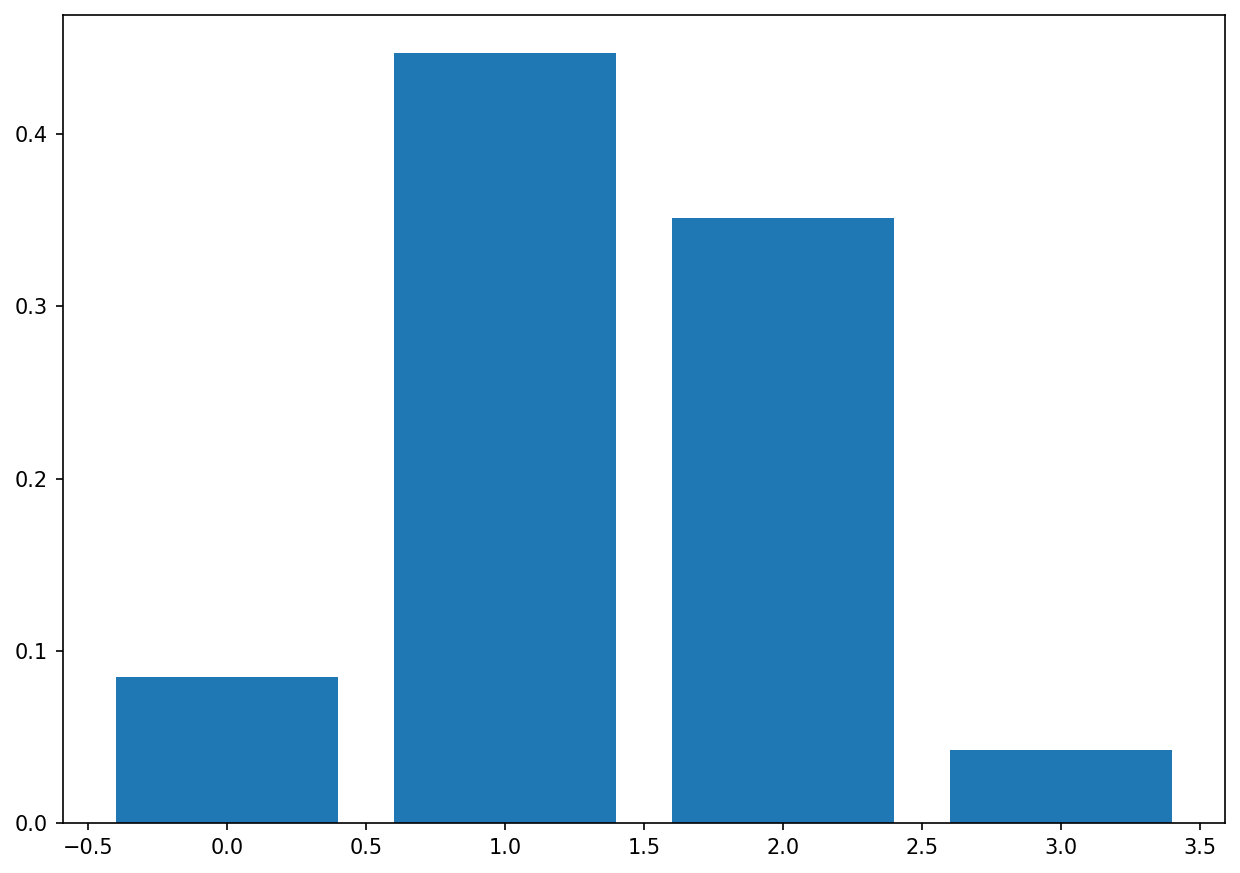

In [10]:
independent_set_probabilities("/Users/riarosenauer/Downloads/aquila_run_1 2")
plot_set_probabilites("/Users/riarosenauer/Downloads/aquila_run_1 2", "test")